In [ ]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
data=pd.read_csv('/content/NFLX.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
1,2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2,2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
3,2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
4,2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000
...,...,...,...,...,...,...,...
1002,2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995,10476100
1003,2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993,5589800
1004,2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002,4766600
1005,2019-12-13,298.500000,301.799988,297.250000,298.500000,298.500000,3879700


In [ ]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=data['Date'],y=data['Open'].rolling(window=14).mean(),name="netflix"),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=500,title_text="NETFLIX")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices",secondary_y=False)
fig.show()

In [ ]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
n=len(data)
train_data=data[0:(n//10)*8]
test_data=data[(n//10)*8:]

In [ ]:
test_data

,Date,Open,High,Low,Close,Adj Close,Volume
800,2019-02-22,360.339996,366.130005,360.049988,363.019989,363.019989,7088200
801,2019-02-25,367.010010,371.489990,363.790009,363.910004,363.910004,7569300
802,2019-02-26,362.980011,365.700012,359.329987,364.970001,364.970001,4944600
803,2019-02-27,363.500000,368.029999,359.799988,362.869995,362.869995,5629900
804,2019-02-28,362.470001,366.390015,357.709991,358.100006,358.100006,6186800
...,...,...,...,...,...,...,...
1002,2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995,10476100
1003,2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993,5589800
1004,2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002,4766600
1005,2019-12-13,298.500000,301.799988,297.250000,298.500000,298.500000,3879700


In [ ]:
print(len(train_data))
print(len(test_data))


800
207


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['Open'].values.reshape(-1,1))

In [ ]:
prediction_days = 30

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)-10):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+10, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
print(x_train.shape)
print(y_train.shape)

(760, 30, 1)
(760,)


In [ ]:
def LSTM_model():

    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    return model

In [ ]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 1, save_best_only = True)
his=model.fit(x_train,y_train,epochs=20,batch_size=32,callbacks=[checkpointer])

Epoch 1/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0374 - accuracy: 0.0014

24/24 [==============================] - 7s 47ms/step - loss: 0.0367 - accuracy: 0.0013
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.0013

24/24 [==============================] - 2s 80ms/step - loss: 0.0081 - accuracy: 0.0013
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.0013

24/24 [==============================] - 2s 79ms/step - loss: 0.0076 - accuracy: 0.0013
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.0013

24/24 [==============================] - 2s 65ms/step - loss: 0.0082 - accuracy: 0.0013
Epoch 5/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.0014

24/24 [==============================] - 1s 47ms/step - loss: 0.0074 - accuracy: 0.0013
Epoch 6/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0069 - accuracy: 0.0014

24/24 [==============================] - 1s 47ms/step - loss: 0.0070 - accuracy: 0.0013
Epoch 7/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0073 - accuracy: 0.0014

24/24 [==============================] - 1s 47ms/step - loss: 0.0075 - accuracy: 0.0013
Epoch 8/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0091 - accuracy: 0.0014

24/24 [==============================] - 1s 46ms/step - loss: 0.0090 - accuracy: 0.0013
Epoch 9/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0072 - accuracy: 0.0014

24/24 [==============================] - 1s 46ms/step - loss: 0.0070 - accuracy: 0.0013
Epoch 10/20
24/24 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.0013

24/24 [==============================] - 1s 47ms/step - loss: 0.0060 - accuracy: 0.0013
Epoch 11/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.0014    

24/24 [==============================] - 1s 46ms/step - loss: 0.0061 - accuracy: 0.0013
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.0013

24/24 [==============================] - 1s 47ms/step - loss: 0.0063 - accuracy: 0.0013
Epoch 13/20
24/24 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.0013

24/24 [==============================] - 2s 64ms/step - loss: 0.0065 - accuracy: 0.0013
Epoch 14/20
24/24 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.0013

24/24 [==============================] - 2s 80ms/step - loss: 0.0065 - accuracy: 0.0013
Epoch 15/20
24/24 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.0013

24/24 [==============================] - 2s 79ms/step - loss: 0.0062 - accuracy: 0.0013
Epoch 16/20
24/24 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.0013

24/24 [==============================] - 1s 47ms/step - loss: 0.0063 - accuracy: 0.0013
Epoch 17/20
24/24 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.0013

24/24 [==============================] - 1s 47ms/step - loss: 0.0062 - accuracy: 0.0013
Epoch 18/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0066 - accuracy: 0.0014

24/24 [==============================] - 1s 47ms/step - loss: 0.0065 - accuracy: 0.0013
Epoch 19/20
24/24 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.0013

24/24 [==============================] - 1s 47ms/step - loss: 0.0058 - accuracy: 0.0013
Epoch 20/20
24/24 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.0013

24/24 [==============================] - 1s 48ms/step - loss: 0.0057 - accuracy: 0.0013


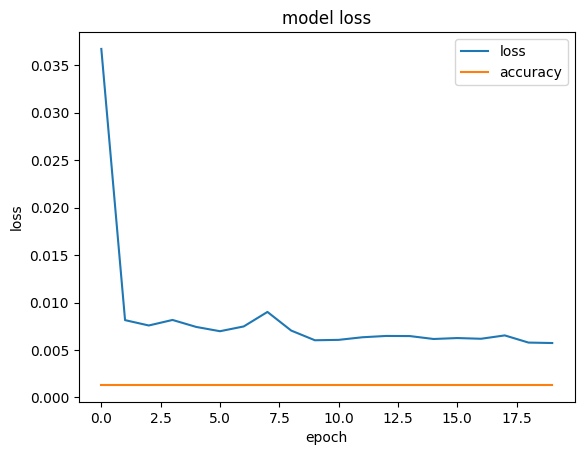

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper right')
plt.show()

In [ ]:
actual_prices = test_data['Open'].values
total_dataset = pd.concat((train_data['Open'], test_data['Open']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

7/7 [==============================] - 2s 13ms/step


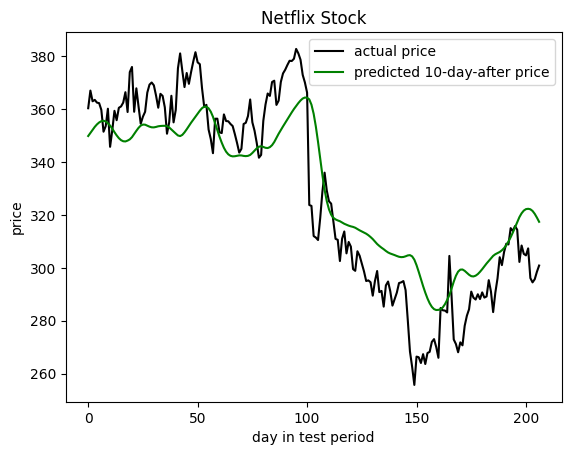

In [ ]:
plt.plot(actual_prices, color='black', label=f"actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted 10-day-after price")
plt.title(f"Netflix Stock")
plt.xlabel("day in test period")
plt.ylabel(f"price")
plt.legend()
plt.show()

In [ ]:
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))
print(real_data.shape)

(1, 29, 1)


In [ ]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 1s/step
prediction: 316.0467529296875
